In [1]:
# this notebook builds off of what was being done in the V2 notebook. I got a lot to work there, so this notebook cleans up
# the code found in that notebook and adds a bit more!

# besides removing some extraneous figures / print statements, this notebook checks to make sure that the bin sorting 
# algorithm works, and a new method to cut data down to rmw < 1 to compare with previous methods :)
# it also saves a cleaned up xarray dataset with added x axes in obj-data-analysis/homework2 for easy access!

In [37]:
# import...
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import sys

import warnings
import pandas as pd
from scipy.signal import find_peaks

# helpful for making maps with cartopy
import matplotlib.patches as mpatches
import shapely.geometry as sgeom
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from geopy import distance

os.chdir("/Users/etmu9498/research/code/scripts")
import make_plots_new_heights
import make_plots
import tc_metadata
import helper_fns

os.chdir("/Users/etmu9498/research/code/scripts/in-situ-scripts")
import load_in_situ_data

sys.path.append("/Users/etmu9498/research/code/scripts/plotting")
import rmw_inner_outer_stats as extra_stats # confidence interval function resides here!
import fl_vpeaks_algorithms as peak_algs
import fl_mean_plots_error

sys.path.append("/Users/etmu9498/research/code/scripts/obj-data-analysis")
import ch1_statistics # confidence interval function resides here!


In [38]:
# load one new sam dataset for testing

fl_new_path = "/Users/etmu9498/research/data/in-situ-noaa-full/2021/"
os.chdir(fl_new_path)
samname = '20210925H1_sam.nc' # '20210929H2_sam.nc' # change me!
sam_data = xr.open_dataset( samname, decode_times=False)
tcname = 'sam'

In [39]:
# creating the time (decimal) axis
# interval_str holds the start and end times as a string. cut down interval_str to get the start hour, min, sec!
interval_str = sam_data.attrs['TimeInterval']
h = float( interval_str[0:2])
m = float( interval_str[3:5])
s = float( interval_str[6:8])
start_time = h + m / 60 + s / 3600

# create the time array manually
time = np.empty( ( len( sam_data['Time'])))
for timei in range( len( sam_data['Time'])):
    # add to time array
    time[ timei] = start_time + timei / 3600    
sam_data['float_time'] = time

print( 'Time array saved')

Time array saved


In [40]:
###############################
# load the file holding tc position / track info for each tc
###############################

# load the track data for each unique tc name! Save it in a nice pandas dataframe
# iteratively save them in the list below    
track_data_list = []
track_file_path = "/Users/etmu9498/research/data/track/"
filename = tcname + "2021.trak"
col_names = ['date', 'time (UTC)', 'lat', 'lat dir', 'lon', 'lon dir']

track_data = pd.read_fwf( track_file_path + filename, skiprows=3, names = col_names)

# add a new column with time as a decimal
float_times = []
for ind in range( np.shape( track_data)[0]):
    str_timei = track_data['time (UTC)'][ ind]

    # calculate the decimal time
    h = float( str_timei[0:2])
    m = float( str_timei[3:5]) 
    s = float( str_timei[6:8]) 

    float_times.append( h + m / 60 + s / 3600)
track_data[ 'float_time'] = float_times

# add a new column with the date in the format of new flight level netcdfs
newdates = []
for ind in range( np.shape( track_data)[0]):
    old_datei = track_data.date[ ind]

    newdates.append( old_datei[6:10] + old_datei[0:2]+old_datei[3:5])
track_data[ 'date2'] = newdates

track_data

,date,time (UTC),lat,lat dir,lon,lon dir,float_time,date2
0,09/25/2021,22:01:48,13.286,N,48.575,W,22.030000,20210925
1,09/25/2021,22:03:48,13.288,N,48.577,W,22.063333,20210925
2,09/25/2021,22:05:47,13.289,N,48.580,W,22.096389,20210925
3,09/25/2021,22:07:47,13.291,N,48.582,W,22.129722,20210925
4,09/25/2021,22:09:48,13.293,N,48.584,W,22.163333,20210925
...,...,...,...,...,...,...,...,...
4529,10/02/2021,04:28:08,31.752,N,61.145,W,4.468889,20211002
4530,10/02/2021,04:30:09,31.760,N,61.141,W,4.502500,20211002
4531,10/02/2021,04:32:08,31.769,N,61.136,W,4.535556,20211002
4532,10/02/2021,04:34:09,31.777,N,61.131,W,4.569167,20211002


In [41]:
##########################
# goal:
# trim down the float_time field saved in the track data to just the days / times of the p-3 pass!
##########################
# not just the day referenced in the flight level data's title, but all dates / times in the flight level data! 
# (ex: part of the next day)
# this prevents errors when finding min time differences- if the date range wasn't trimmed, we might find min time
# differences from incorrect days!


# find flight level (fl) time limits for the current and sometimes the next day
fl_date = samname[0:8]
fl_firstt = sam_data.float_time[0].values
fl_lastt = sam_data.float_time[-1].values

# cut off all data before the start of the p-3 data
# find the indices for the times from the first day
current_day_inds = np.where( track_data['date2'] == samname[0:8])[0]

# find the closest time to the start time!
# need to do first_day_inds[0] to account for indices before the start of first_day_inds!
first_t_ind = current_day_inds[0]  + np.argmin( np.abs( track_data['float_time'][ current_day_inds].values - fl_firstt ))

newdate = []
# find the closest time to the end time!
# same day CASE
if fl_lastt < 24.0:
    last_t_ind = current_day_inds[0]  + np.argmin( np.abs( track_data['float_time'][ current_day_inds].values - lastt ))

# new case: the float_time variable shifts into the next day
# need to look at arrays for the next day 
else:
    # find the next day indices.
    # done this way rather than + 1 to account for flips like 9/29 -> 9/30, or 9/31 -> 10/1
    # look through dates from current day to the end of the array
    for datei in track_data['date2'][ current_day_inds[0] : ]:      
        # new date case: save it and end the loop!
        if datei != samname[0:8]:
            newdate = datei
            break
            
    # still in the if statement, find all the inds for this next day
    next_day_inds = np.where( track_data['date2'] == newdate)[0]
    
    # do - 24 to account for the 24 hour shift!
    last_t_ind = next_day_inds[0]  + np.argmin( np.abs( track_data['float_time'][ next_day_inds].values - ( fl_lastt - 24) ))
    
# make the final array!
dayind = range( first_t_ind, last_t_ind)

# tests
print('flight level info:')
print('flight level date =    ' + fl_date)
print('flight level start t = ' + str(fl_firstt))
print('flight level end t =   ' + str(fl_lastt))
print('flight level end t-24 = ' + str(fl_lastt - 24.0) + '\n')

print('center fix limits:')
print('start index = ' + str( first_t_ind))
print( 'start date: ' + str( track_data['date2'][ first_t_ind]))
print( 'start t = ' + str( track_data['float_time'][ first_t_ind]))

print( 'end index = ' + str( last_t_ind))
print( 'end date: ' + str( track_data['date2'][ last_t_ind]))
print( 'end t = ' + str( track_data['float_time'][ last_t_ind]))

flight level info:
flight level date =    20210925
flight level start t = 17.186666666666667
flight level end t =   27.145833333333336
flight level end t-24 = 3.1458333333333357

center fix limits:
start index = 0
start date: 20210925
start t = 22.029999999999998
end index = 154
end date: 20210926
end t = 3.1580555555555554


In [42]:
%%time
# for every lat / lon pair, find the tc center fix closest to its time index. Then, find the distance to the tc center!
dists = []

# defining these variables once outside the loop actually saves a ton of time when accessing them
lat = sam_data.LATref.values
lon = sam_data.LONref.values
samtime = sam_data.float_time.values

track_lat = track_data.lat.values [dayind]
track_lon = - track_data.lon.values [dayind] # values are saved as positive from track .txt document
tracktime = track_data.float_time.values [dayind]
trackdate = track_data.date2.values [ dayind]

# first, account for date changes in the time intervals:
fl_orig_date = samname[0:8] # the date when the first pass was completed

for tracktimei in range( len( tracktime)):
    # new date case: increase the time by 24 hours! 
    if trackdate [ tracktimei] != fl_orig_date:
        tracktime[ tracktimei] += 24.0
        
print('Track Time Corrected: Values Now Go Above 24.0')
        
latnans = 0
lonnans = 0

# other methods don't work for speeding up the distance step...
for fl_i in range( len( sam_data.LATref)):
    lati, loni, timei = lat[ fl_i], lon[ fl_i], samtime[ fl_i]
    
    # find the closest center fix time index!
    
    # if the time difference is too large, don't add this case :/
    # helpful for avoiding edge case errors ( a 15 minute window is used??)
    if np.min( np.abs( tracktime - timei )) > .250 :
        dists.append( np.nan)
        pass
    else:
        center_i = np.argmin( np.abs( tracktime - timei ))
    
        #########################
        ## 2/13/23 new code: make sure that the closest center fix time is at least smaller than 15 minutes (?)
        ## and that the date is within the correct bounds!
        #########################

        center_time = tracktime[ center_i]
        center_date = trackdate[ center_i]

        coords_p3 = np.ma.masked_invalid( ( lati, loni))
        coords_center = np.ma.masked_invalid( ( track_lat[center_i], track_lon[center_i]))    
        center_dist_i = distance.geodesic( coords_p3, coords_center).km

        # nan cases- can't find a distance
        if np.isnan( lati):
            latnans += 1
            center_dist_i = np.nan
        if np.isnan( loni):
            lonnans += 1
            center_dist_i = np.nan

        # otherwise, append a valid distance to the dists list 
        dists.append( center_dist_i)
   
    # nice user notices
    if fl_i == 0:
        print( 'number of flight level data points: ' + str( len( sam_data.LATref)))
    if fl_i % 2500 == 0:
        print( 'index = ' + str( fl_i))
        # print( 'fl time = ' + str( timei))
        # print( 'center time = ' + str( center_time))
        # print( 'center date = ' + str( center_date) + '\n')

    
print('number of lat nans: ' + str( latnans))
print('number of lon nans: ' + str( lonnans))


Track Time Corrected: Values Now Go Above 24.0
number of flight level data points: 35854
index = 0
index = 2500
index = 5000
index = 7500
index = 10000
index = 12500
index = 15000
index = 17500
index = 20000
index = 22500
index = 25000
index = 27500
index = 30000
index = 32500
index = 35000
number of lat nans: 45
number of lon nans: 45
CPU times: total: 5.92 s
Wall time: 5.91 s


In [43]:
#####################################
## 2/13/23 big goal: create an updated rmw axis for all dc distances using the new, precise distance axis!
#####################################

# step 1: find vpeaks using the typical method

# input vars used later
max_v_requirement=40
window=10
timelim = 60

# restating important metadata defined above
fl_path = "/Users/etmu9498/research/data/in-situ-noaa-full/2021/"
os.chdir(fl_new_path)
samname = samname
sam_data = xr.open_dataset( samname, decode_times=False)

fl_data = sam_data

# do this for just the sam case listed above
# load data
title = "All Flight Level Data for Flight " + samname

# creating the axis
# this string holds the start and end times. cut down the interval dataset to get the hours, mins, secs!
interval_str = fl_data.attrs['TimeInterval']
h = float( interval_str[0:2])
m = float( interval_str[3:5])
s = float( interval_str[6:8])
start_time = h + m / 60 + s / 3600

# create the time array manually
# if this is too slow, try using pandas? see stack overflow link below...
# https://stackoverflow.com/questions/55648630/how-to-decode-the-time-variable-while-using-xarray-to-load-a-netcdf-file
time = np.empty( ( len( fl_data['Time'])))
for timei in range( len( fl_data['Time'])):
    # add to time array
    time[ timei] = start_time + timei / 3600

spd_avg = pd.Series( fl_data['WS.d']).rolling(window=window, min_periods=1, center=True).mean()

vpeaks, pmins, time_lims = peak_algs.find_peaks_pmin_time_limit( fl_data['PSURF.d'], spd_avg, time, window, timelim=timelim)

print( 'pressure minima indices: ' + str( pmins))
print( 'velocity peak indices: ' + str(vpeaks))

pressure minima indices: [17785 20869 24372]
velocity peak indices: [17738, 17922, 20765, 20975, 24272, 24458]


In [44]:
# step 2: find distances at each wind speed peak. Use these distances to define a new rmw axis. 
# go through a couple if statements to determine which rmw1 value to use as the rmw limit
print( 'Distances from TC center (km) for: ')

rmw0_vals = []
for peak in pmins:
    rmw0_vals.append( dists[ peak])
print( 'pressure minima: ' + str( rmw0_vals))

rmw1_vals = []
for peak in vpeaks:
    rmw1_vals.append( dists[ peak])
print( 'velocity peaks: ' + str( rmw1_vals))


Distances from TC center (km) for: 
pressure minima: [1.3690345773237886, 2.5231579584861703, 2.7044677329178044]
velocity peaks: [7.339901194280766, 16.160437769648297, 14.809701461435374, 10.430105373318877, 13.656543662328387, 12.108855995465579]


In [27]:
#######################
## testing using distance mins ( also velocity mins), rather than pressure mins, to find the center?!
## these methods might be better, but it kinda sounds too complicated for right now lol
#######################

#distmins = find_peaks( x= - np.array( dists), prominence = 25.0)[0]
#print( distmins)

#vmins = find_peaks( x= - spd_avg, prominence = 15.0)[0]
#print( vmins)

In [45]:
# divide up the distance axis into distinct RMW regions
# do this for every peak
rmwlist = []
rainbandlist = []
for vpeaki, vpeak in enumerate( vpeaks):

    print( 'vpeak index = ' + str( vpeaki))
    
    # figure out the distances to the peak winds and current pressure center
    rmw1 = rmw1_vals[ vpeaki]
    # use // to get rid of remainder
    pressurei = vpeaki // 2
    rmw0 = rmw0_vals[ pressurei]
    
    # first value case: count everything before the first wind speed to the center
    if vpeaki == 0:
        # divide by rmw1 so that the distance at the peak winds = 1!
        rmwlist += (np.array( dists [ 0 : pmins[ pressurei] ]) / rmw1).tolist() 
        
        continue
        
    # last value case: count everything from the last center to the end of the dataset
    elif vpeaki == len( vpeaks) - 1:
        rmwlist += (np.array( dists [ pmins[ pressurei] : len( dists)]) / rmw1).tolist() 
        
        continue
        
    # middle cases: things are more complicated lol
    
    # odd cases: the center has already been passed
    elif vpeaki % 2 == 1:        
        # find the index in the rainbands
        # should be halfway between the two closest pressure centers
        # first pressure center + ( difference / 2)
        rainband_ind = int( pmins[ pressurei] + ( ( pmins[ pressurei + 1] - pmins[ pressurei]) / 2) )
        
        rainbandlist.append( rainband_ind)
        print( 'rainband index = ' + str( rainband_ind))
        
        # go from the previous pressure center to a defined point in the outer rainbands
        rmwlist += ( np.array( dists [ pmins[ pressurei] : rainband_ind]) / rmw1).tolist() 
        
    # even cases: the center is being approached
    elif vpeaki % 2 == 0:
        # find the index in the rainbands
        rainband_ind = int( pmins[ pressurei - 1] + ( ( pmins[ pressurei ] - pmins[ pressurei - 1]) / 2) )

        rainbandlist.append( rainband_ind)
        print( 'rainband index = ' + str( rainband_ind))

        # go from the past halfway mark out in the rainbands to the next pressure center
        rmwlist += ( np.array( dists [ rainband_ind : pmins[ pressurei] ]) / rmw1).tolist() 
        
        
    else:
        print( "Error: idk how this happened lol")
        
sam_data['rmw'] = rmwlist
sam_data['dist'] = dists
sam_data['float_time'] = time

        
# testing
print( 'length of dist array = ' + str( len( rmwlist)))
print( 'length of rmw array =  ' + str( len( rmwlist)))

vpeak index = 0
vpeak index = 1
rainband index = 19327
vpeak index = 2
rainband index = 19327
vpeak index = 3
rainband index = 22620
vpeak index = 4
rainband index = 22620
vpeak index = 5
length of dist array = 35854
length of rmw array =  35854


In [11]:
# don't use this code, it's like 500x slower than the code below haha!

'''
%%time

#####################################
## the code above seems to work! at least with a couple simple cases
## next step: repeat stats analysis conducted using a standard rmw axis, but for all rmw values now!! 
## this is super cool, stats can be calculated for regions outside the eyewall too :) :) :) :) 
##
## code below taken from fl_mean_plots_error.py
## this code might possibly work, but it takes wayyyy too long with the additional data points and bin widths :/
#####################################

# input variables
input_vars = [ 'dist', 'rmw', 'float_time', 'WS.d', 'UWZ.d', 'SfmrRainRate.1', 'THETAE.d', 'MR.d', 'TA.d'] # change me!
var_names = [ 'dist', 'rmw', 'time', 'wind_speed', 'w', 'Rain Rate', 'Theta E', 'Mixing Ratio', 'temp']  # change me!


######################
## bin rmw data!
######################

# initialize the dataframe to save binned data
df_binned = pd.DataFrame( )


# pick a bin width for rmw values, sort velocities into those bins, and
# calculate important quantities like the mean, standard deviation, and confidence levels!
binwidth = .1 # for testing with larger RMW scale

# make an array representing the bins!
bins = np.arange(0, 10, step=binwidth) # 20 is also being used for testing: nothing interesting beyond that


# create an array of midpoints (right between two given binwidths)
# will be 1 val shorter than bins array
# used for plotting later
midpoints = []
for i in range( len( bins) - 1):
    midpoints.append( (bins[ i] + bins[ i+1]) / 2)

# the same as the list above but saved in array form, helpful during loop1
midpointarray = np.array( midpoints)

#print( bins)
#print( midpoints)
#print( type( midpointarray))

# add midpoints and bins to the data array
df_binned[ 'bins'] = bins[ 0: len( bins)-1] # drop last value for correct array size
df_binned[ 'midpoints'] = midpoints

nancount = 0


########################
## actually do the averaging within each bin!!
########################

# do this for every variable
for var_i in range( len( input_vars)):

    
    input_field = input_vars[ var_i]
    print( 'Adding Variable: ' + input_field)

    
    # this variable holds the sorted contents for each input field!
    # it starts as an empty list of lists
    sorted_var = []
    for i in range( len( bins) - 1):
        sorted_var.append( [])

    data_field = sam_data[ input_field ]

    
    # sort through every rmw axis value for a given eye pass: check if it's within the bin!
    for rmw_i in range( len( sam_data['rmw'] )):

        # locally define the current value for convenience :)
        rmw_val = sam_data['rmw'][rmw_i]


        if np.isnan( rmw_val):   
            nancount += 1
        else:
            # print( midpointarray)
            # print( rmw_val.values)

            # new method: use array subtraction to find the closest midpoint to the given rmw_i
            closebini = np.argmin( np.abs( midpointarray - rmw_val.values ))
            sorted_var[ closebini].append( data_field[rmw_i].values )

        if rmw_i % 10000 == 0:
            print( "Index " + str( rmw_i))
            
    # after going through every pass for this variable, add the results to the dataframe!
    df_binned[ var_names[ var_i ] ] = sorted_var
    
'''

'\n%%time\n\n#####################################\n## the code above seems to work! at least with a couple simple cases\n## next step: repeat stats analysis conducted using a standard rmw axis, but for all rmw values now!! \n## this is super cool, stats can be calculated for regions outside the eyewall too :) :) :) :) \n##\n## code below taken from fl_mean_plots_error.py\n## this code might possibly work, but it takes wayyyy too long with the additional data points and bin widths :/\n#####################################\n\n# input variables\ninput_vars = [ \'dist\', \'rmw\', \'float_time\', \'WS.d\', \'UWZ.d\', \'SfmrRainRate.1\', \'THETAE.d\', \'MR.d\', \'TA.d\'] # change me!\nvar_names = [ \'dist\', \'rmw\', \'time\', \'wind_speed\', \'w\', \'Rain Rate\', \'Theta E\', \'Mixing Ratio\', \'temp\']  # change me!\n\n\n######################\n## bin rmw data!\n######################\n\n# initialize the dataframe to save binned data\ndf_binned = pd.DataFrame( )\n\n\n# pick a bin width fo

In [12]:
# save the dataframe bc this takes way too long lol
#savedir = "/Users/etmu9498/research/data/in-situ-binned-averages/new-rmw-method"
#os.chdir( savedir)
#filename = "old_binning_method_case_9_29_21.pkl"
#df_binned.to_pickle( filename) 

In [29]:
%%time
# a repeat of the cell above, but looping through all variables in the inner loop to save time!
# locally define things here again for clarity

# input variables
input_vars = [ 'dist', 'rmw', 'float_time', 'WS.d', 'UWZ.d', 'SfmrRainRate.1', 'THETAE.d', 'MR.d', 'TA.d'] # change me!
var_names = [ 'dist', 'rmw', 'time', 'wind_speed', 'w', 'Rain Rate', 'Theta E', 'Mixing Ratio', 'temp']  # change me!

# initialize a new dataframe to save binned data
df_new_bins = pd.DataFrame( )

binwidth = .01 
# make an array representing the bins!
bins = np.arange(0, 10, step=binwidth)


# create an array of midpoints (right between two given binwidths)
midpoints = []
for i in range( len( bins) - 1):
    midpoints.append( (bins[ i] + bins[ i+1]) / 2)
midpointarray = np.array( midpoints)


# add midpoints and bins to the data array
df_new_bins[ 'bins'] = bins[ 0: len( bins)-1] # drop last value for correct array size
df_new_bins[ 'midpoints'] = midpoints

nancount = 0

# print( midpoints)
    
################
## new
## the list below holds about 10 empty lists, one for each of the input_vars.
## for each variable, there are len( midpoints) empty lists to hold each sorted data point
## structure
################
total_vars = []
for i in range( len( input_vars)):   
    temp_list = []
    # make empty lists for midpoints
    for j in range( len( midpoints)):
        temp_list.append( [])
    total_vars.append( temp_list)
    
print( "Length of RMW axis = " + str( len( sam_data['rmw'] )))

# save all relevant fields as numpy arrays rather than xarray: saves computing time!
rmwvals = sam_data['rmw'].values
datalist = []
for i in range( len( input_vars)):
    datalist.append( sam_data[ input_vars[i]].values)

# sort through every rmw axis value for a given eye pass: check if it's within the bin!
for rmw_i, rmw_val in enumerate( rmwvals ):

    # do nothing for nans
    if np.isnan( rmw_val):   
        nancount += 1
    else:
        # new method: use array subtraction to find the closest midpoint to the given rmw_i
        bin_i = np.argmin( np.abs( midpointarray - rmw_val ))
        
        # do this for every input variable!
        for var_i, var_val in enumerate( datalist):
            # add the singular value for this variable to the correct spot in the total binned array
            total_vars[ var_i][ bin_i].append( var_val[ rmw_i])
            
    if rmw_i % 10000 == 0:
        print( "Index " + str( rmw_i))


# transfer the list of lists of lists (lol) to a nice pandas format!
for col_i, col_val in enumerate( total_vars):
    df_new_bins[ var_names[ col_i ] ] = col_val
    

Length of RMW axis = 35854
Index 0
Index 10000
Index 20000
Index 30000
CPU times: total: 453 ms
Wall time: 457 ms


In [15]:
# save the new dataframe for comparisons
savedir = "/Users/etmu9498/research/data/in-situ-binned-averages/new-rmw-method"
os.chdir( savedir)
filename = "new_binning method_case_9_29_21.pkl"
df_new_bins.to_pickle( filename) 

In [16]:
###########################################
## 2/17 new code
## test to make sure that super slow code and super fast code have the same outputs! they should
###########################################

# load the locally saved data!
os.chdir("/Users/etmu9498/research/data/in-situ-binned-averages/new-rmw-method/")

# old case
# test_df = pd.read_pickle( 'new_binning method_case_9_29_21.pkl')

# new case
test_df = pd.read_pickle( 'new_binning method_case_9_29_21.pkl')

Confidence intervals found for dist
Confidence intervals found for rmw
Confidence intervals found for time
Confidence intervals found for wind_speed
Confidence intervals found for w
Confidence intervals found for Rain Rate
Confidence intervals found for Theta E
Confidence intervals found for Mixing Ratio
Confidence intervals found for temp


Text(0.5, 0, 'Radius of Maximum Wind')

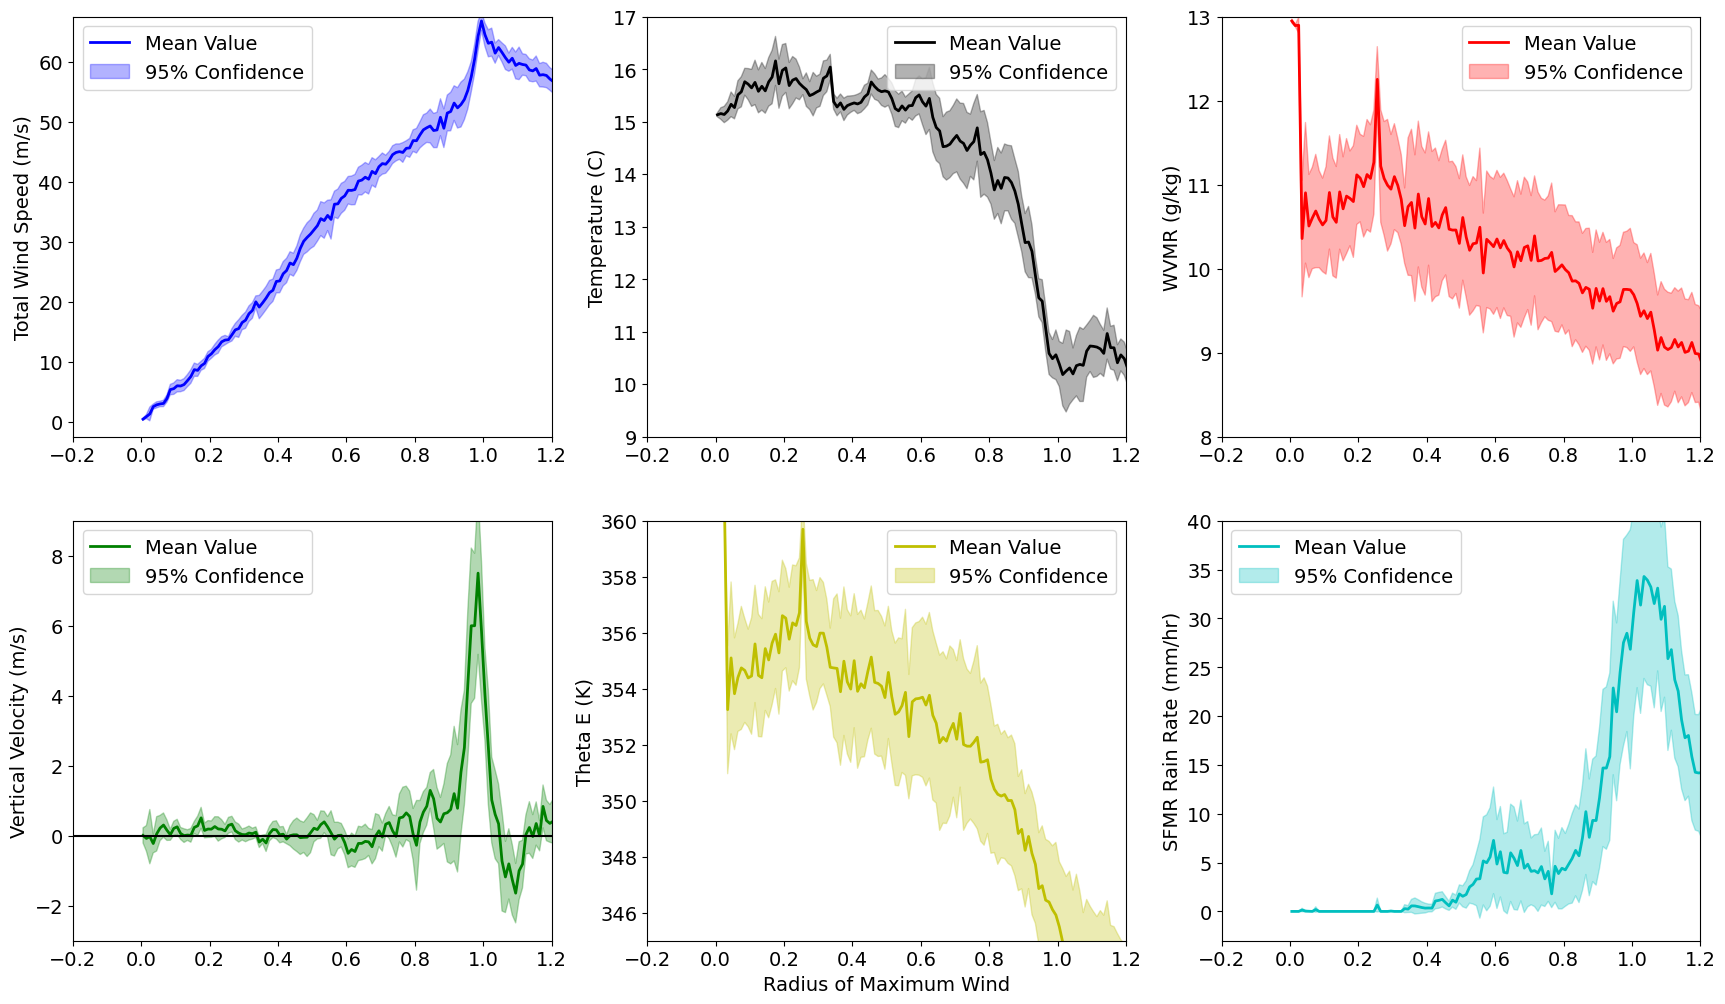

In [30]:
confidence = .95

for var_i in range( len( var_names)):
    var_mean, var_lowc, var_highc = [], [], []

    field = test_df[ var_names[ var_i] ]

    # do this for every bin for that variable
    for i in range( len( test_df[ 'midpoints'] )):

        # np.ma.masked_array( field[ i], np.isnan( field[ i]))
        mean, lowc, highc = ch1_statistics.t_test_intervals(
                    field[i], confidence=confidence)
        var_mean.append(  mean)
        var_lowc.append(  lowc)
        var_highc.append(  highc)

    # after going through every pass for this variable, add the results to the dataframe!
    test_df[ var_names[ var_i] + "_mean"] = var_mean
    test_df[ var_names[ var_i] + "_highc"] = var_highc
    test_df[ var_names[ var_i] + "_lowc"] = var_lowc

    print( "Confidence intervals found for " + var_names[ var_i])

    
df = test_df
    
# make an error plot 
plt.figure( figsize=(21, 12))
lw = 2.
helper_fns.change_font_sizes(14, 14)

# make plots of total wind speed and vertical vels along new rmw axes!
plt.subplot(231)

subplots = [ 231, 232, 233, 234, 235, 236]
ylabels = [ "Total Wind Speed (m/s)", "Temperature (C)", "WVMR (g/kg)", "Vertical Velocity (m/s)", "Theta E (K)",
          "SFMR Rain Rate (mm/hr)"]
colors = ['b', 'k', 'r', 'g', 'y', 'c']

ylimits = [ [-2.5, 60], [9, 17], [9, 14], 
          [-4, 6], [350, 365], [-3, 35] ]

ylimits = [ [-2.5, 67.5], [9, 17], [8, 13], 
          [-3, 9], [345, 360], [-3, 40] ]

# use the var_names list defined way earlier for plotting!
new_var_names = ['wind_speed', 'temp', 'Mixing Ratio', 'w', 'Theta E', 'Rain Rate' ]

for i in range( len( subplots)):

    plt.subplot( subplots[ i])
    plt.ylabel(ylabels[ i])
    plt.xlim( [-.2, 1.2])
    plt.ylim( ylimits[ i])
    plt.plot( df[ 'midpoints'], df[ new_var_names[ i] + '_mean'], c=colors[i], linewidth=lw, label="Mean Value")

    ax = plt.gca()
    ax.fill_between( df[ 'midpoints'], df[ new_var_names[ i] + '_lowc'], df[ new_var_names[ i] + '_highc'],
                    color=colors[i], alpha=0.3, label=str( int(confidence*100)) + "% Confidence")
    ax.legend()

plt.subplot(234)
plt.axhline(y=0, linewidth = 1.5, c='k')

plt.subplot(235)
plt.xlabel("Radius of Maximum Wind")


In [21]:
###########################################
## new code for this notebook
## task 1) save this xarray dataset in my classwork folder for easy completion of HW2!
###########################################
input_vars = [ 'dist', 'rmw', 'float_time', 'WS.d', 'UWZ.d', 'SfmrRainRate.1', 'THETAE.d', 'MR.d', 'TA.d', 'PSURF.d'] # change me!
sam_data_trim = sam_data[ ['Time', 'HT.d', 'THETA.d', 'THETAV.d'] + input_vars]

savedir = "/Users/etmu9498/classes/obj-data-analysis/homework2/"
filename = "ATOC5860_HW2_Murray_extra_data.nc"
# sam_data_trim.to_netcdf(savedir + filename) # uncomment to save!


Current year: 2021
Dataset 0 loaded
Auto variables added
Chosen variables added
Pandas dataframe 1 saved
Variable added: rmw
Variable added: Time
Variable added: wind_speed
Variable added: w
Variable added: Rain Rate
Variable added: Theta E
Variable added: Mixing Ratio
Variable added: temp
Pandas dataframe 2 saved
Confidence intervals found for rmw
Confidence intervals found for Time
Confidence intervals found for wind_speed
Confidence intervals found for w
Confidence intervals found for Rain Rate
Confidence intervals found for Theta E
Confidence intervals found for Mixing Ratio
Confidence intervals found for temp


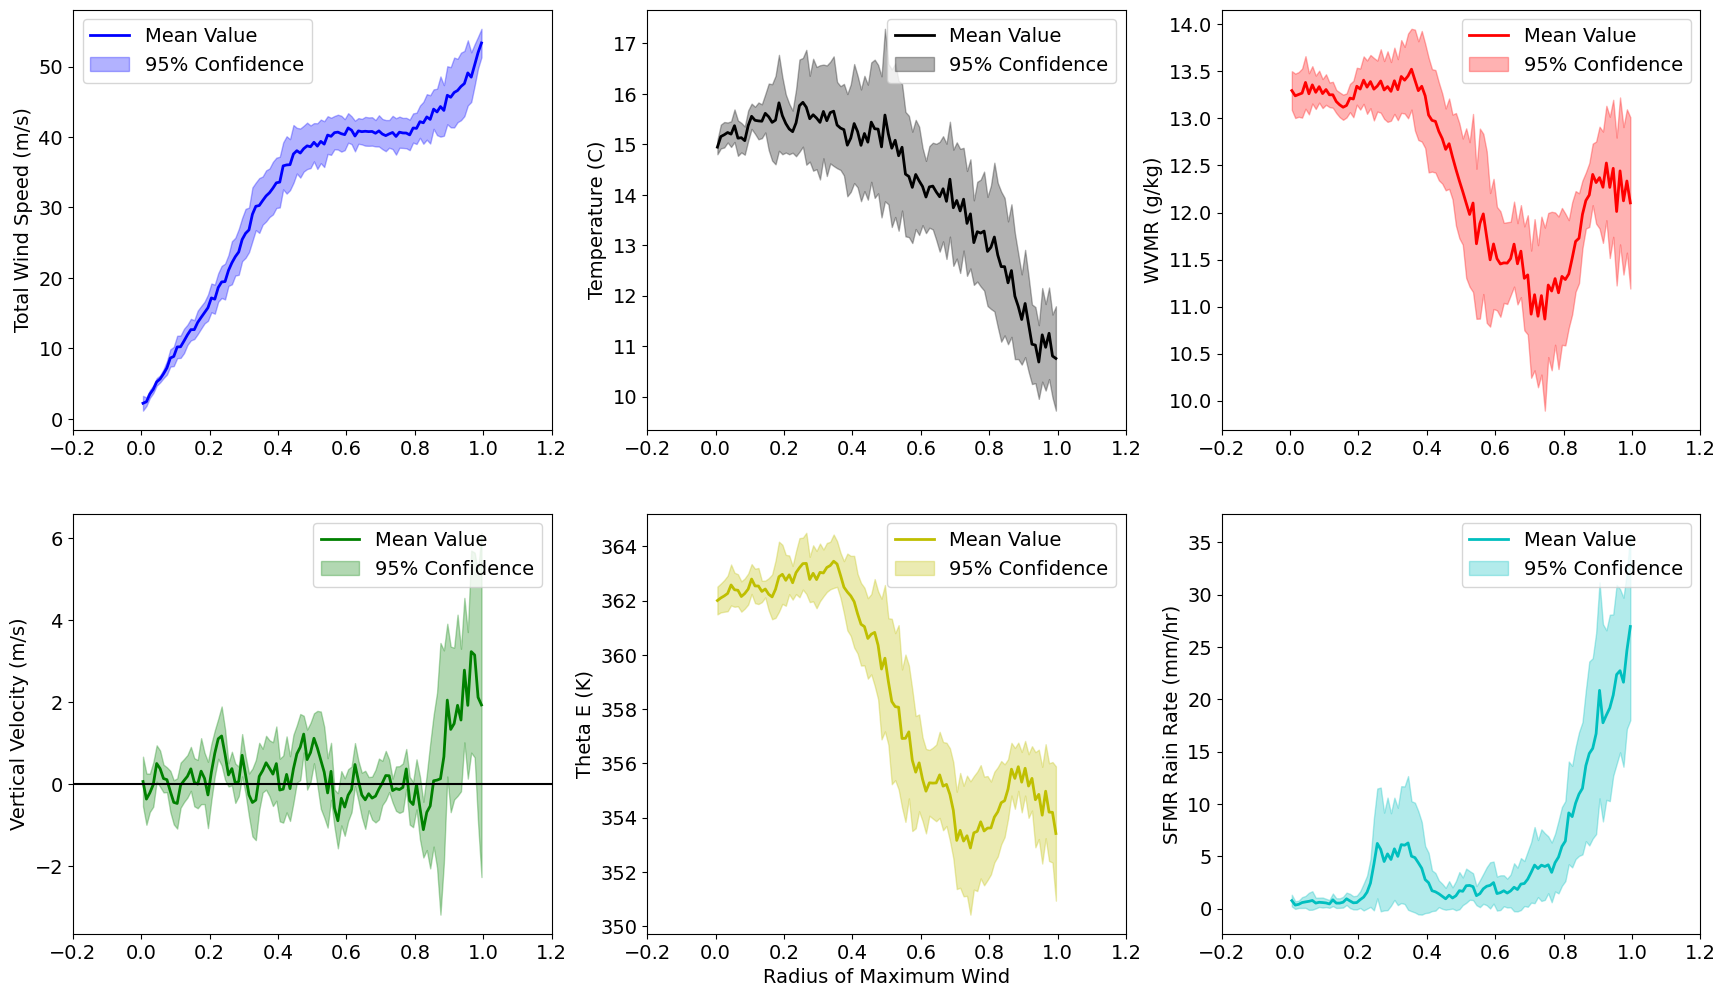

In [41]:
##################
## task 2) check to make sure that the bin sorting algorithm works
# result: it does! at least for 9/27/21
#####################


# run code creating the auto binned data for this day!
tcdict = {}
tcdict['2021'] = [samname]
fl_mean_plots_error.make_plot( tc = tcdict, max_v_requirement=40, save_datasets=True)

# save the pandas dataframe created above for easy access below :)
os.chdir("/Users/etmu9498/research/data/in-situ-binned-averages/")
df_binned.to_pickle("binned_values_new_rmw.pkl")


In [42]:
# load the locally saved data!
os.chdir("/Users/etmu9498/research/data/in-situ-binned-averages/")
new_rmw_binned_data = pd.read_pickle( 'binned_values_new_rmw.pkl')


In [43]:
# new_rmw_binned_data

In [31]:
# look at individual bin indices: do the rmw's match what we expect?
# results: the sorting algorithm works perfectly! all the rmws fall within the correct bins

index = 5
df = new_rmw_binned_data

print("index = " + str( index))
print("bin limits = " + str( df[ 'bins'][index]) + " and " + str( df[ 'bins'][ index + 1]))
print("bin midpoint = " + str( df[ 'midpoints'][index]) )

# check if all rmws fall within the limits
plt.figure( figsize=(10, 9))

plt.subplot(211)
plt.scatter( range( len( df['rmw'][index])), df['rmw'][ index], c='r', alpha=.7)
plt.xlabel( "Data point count")
plt.ylabel('RMW Value')
plt.grid()

plt.subplot(212)
plt.scatter(  df['rmw'][index], df['wind_speed'][ index], c='b', alpha=.5)
plt.xlabel("RMW")
plt.ylabel("Variable value")
plt.grid()

NameError: name 'new_rmw_binned_data' is not defined

In [32]:
#######################
## task 3) cut data down to rmw < 1 to compare with previous methods :)
#######################

Text(0.5, 0, 'Radius of Maximum Wind')

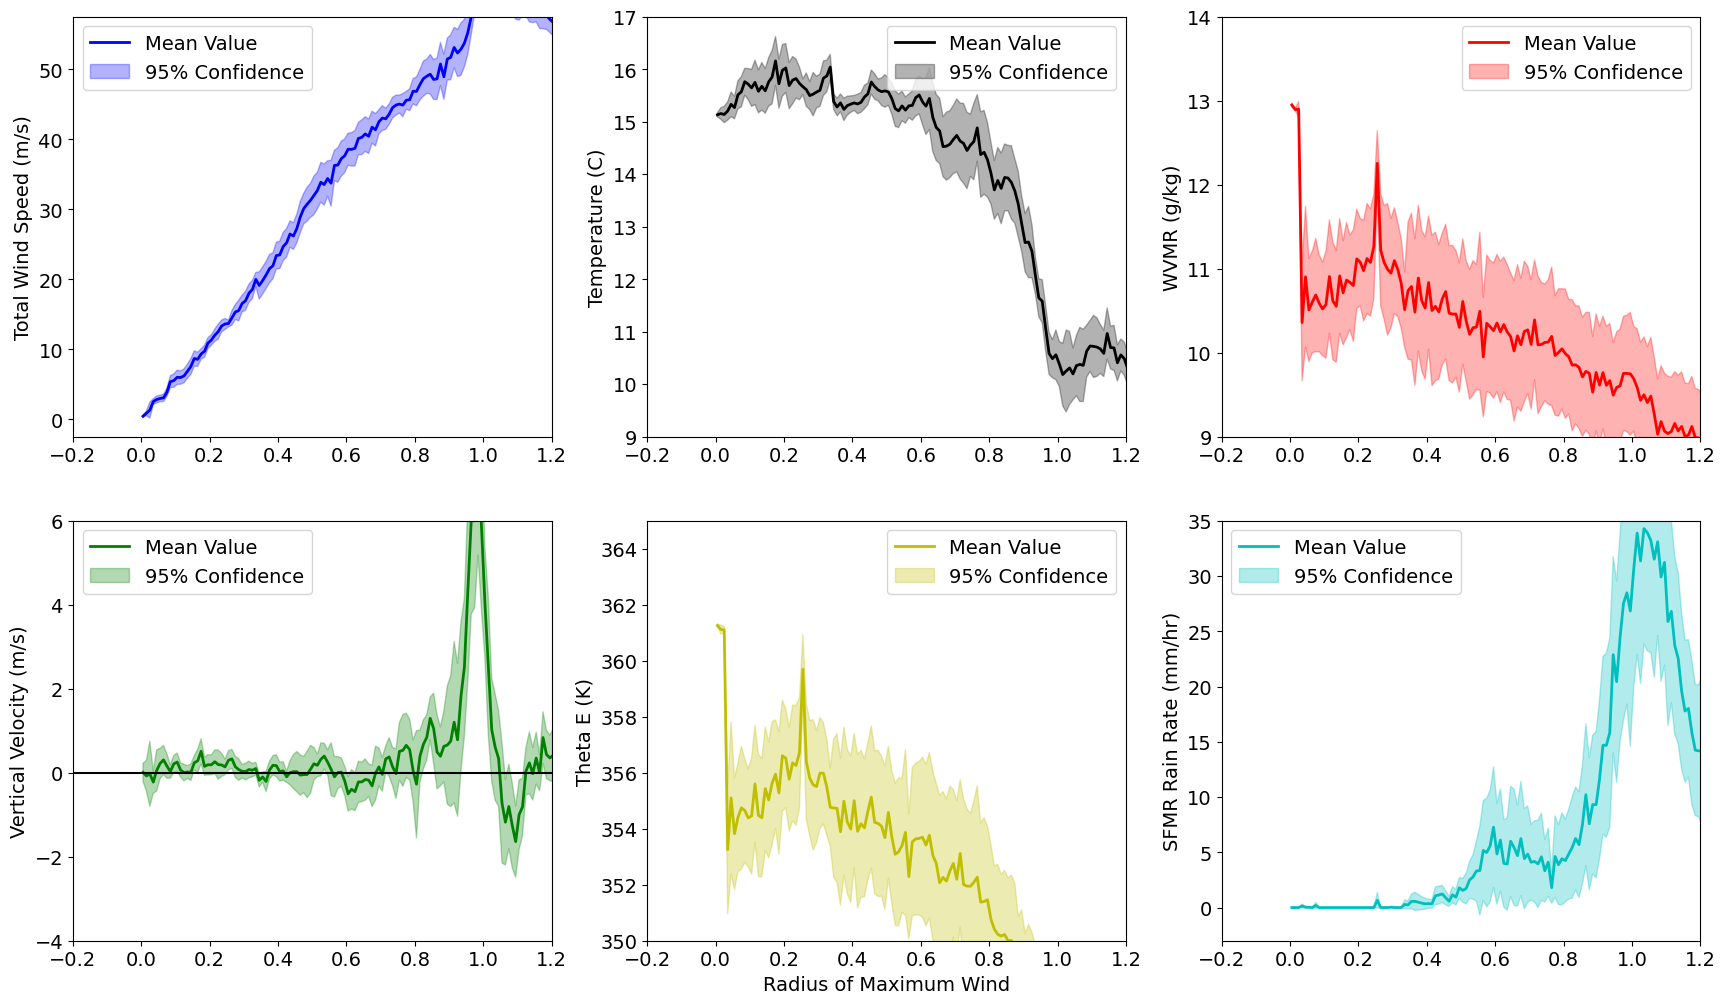

In [33]:
# use the error plot 
plt.figure( figsize=(21, 12))
lw = 2.
helper_fns.change_font_sizes(14, 14)

# make plots of total wind speed and vertical vels along new rmw axes!
plt.subplot(231)

subplots = [ 231, 232, 233, 234, 235, 236]
ylabels = [ "Total Wind Speed (m/s)", "Temperature (C)", "WVMR (g/kg)", "Vertical Velocity (m/s)", "Theta E (K)",
          "SFMR Rain Rate (mm/hr)"]
colors = ['b', 'k', 'r', 'g', 'y', 'c']

ylimits = [ [-2.5, 57.5], [9, 17], [9, 14], 
          [-4, 6], [350, 365], [-3, 35] ]
# use the var_names list defined way earlier for plotting!
new_var_names = ['wind_speed', 'temp', 'Mixing Ratio', 'w', 'Theta E', 'Rain Rate' ]

for i in range( len( subplots)):

    plt.subplot( subplots[ i])
    plt.ylabel(ylabels[ i])
    plt.xlim( [-.2, 1.2])
    plt.ylim( ylimits[ i])
    plt.plot( df[ 'midpoints'], df[ new_var_names[ i] + '_mean'], c=colors[i], linewidth=lw, label="Mean Value")

    ax = plt.gca()
    ax.fill_between( df[ 'midpoints'], df[ new_var_names[ i] + '_lowc'], df[ new_var_names[ i] + '_highc'],
                    color=colors[i], alpha=0.3, label=str( int(confidence*100)) + "% Confidence")
    ax.legend()

plt.subplot(234)
plt.axhline(y=0, linewidth = 1.5, c='k')

plt.subplot(235)
plt.xlabel("Radius of Maximum Wind")


In [46]:
######################

# just adding some empty space lol





















In [ ]:
############################################
#
# Additional code to create nice figures for visualizations!
# 
############################################

TC track added
P-3 flight path added


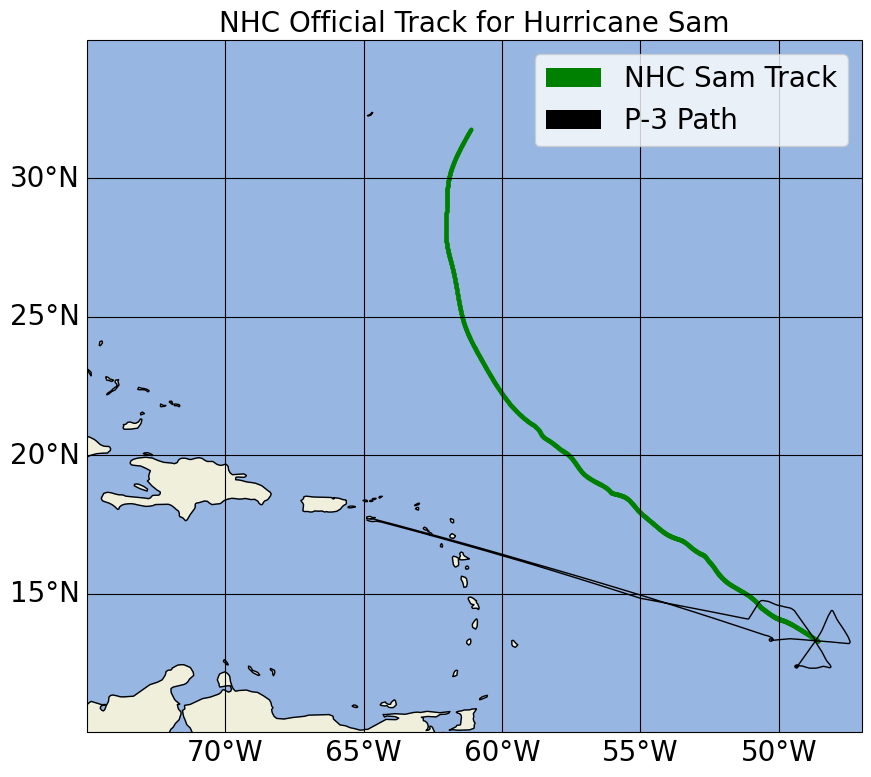

In [34]:
# make a line plot of this tc's track to check out the resolution of its path!

fig = plt.figure( figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
helper_fns.change_font_sizes(20, 20)

# zoomed out   
ax.set_extent([-75, -47, 10, 35], crs=ccrs.PlateCarree())
# zoomed in   
# 9/26
# ax.set_extent([-55, -45, 10, 20], crs=ccrs.PlateCarree()) # zooming in further leads to an odd error :/
# 9/29
# ax.set_extent([-60, -56, 17, 23], crs=ccrs.PlateCarree()) # zooming in further leads to an odd error :/

gl = ax.gridlines( draw_labels=True, color="k")
gl.top_labels = False
gl.right_labels = False

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)

# plot tc sam's track ( remove [dayind] to plot all track data, not just for the fl interval)
lat = track_data.lat # [dayind]
lon = - track_data.lon # [dayind]   
proj = ccrs.PlateCarree()
img2 = ax.scatter( lon, lat, c = 'g', transform= proj, s= 2.5, marker='o' )

print( 'TC track added')

# plot the flight level data atop tc sam's path
lat2 = sam_data.LATref[::10]
lon2 = sam_data.LONref[::10]    
track2 = sgeom.LineString(zip(lon2, lat2))

ax.add_geometries([track2], ccrs.PlateCarree(),
                  facecolor='none', edgecolor='k')                          

r = [ mpatches.Rectangle((0, 0), 1, 1, facecolor="g"), mpatches.Rectangle((0, 0), 1, 1, facecolor="k")]
labels = ['NHC Sam Track', 'P-3 Path']
ax.legend( r, labels)


print( "P-3 flight path added")

ax.set_title( "NHC Official Track for Hurricane Sam")
ax.set_xlabel( "Longitude (Degrees)")
ax.set_ylabel( "Latitude (Degrees)")
plt.show()


(0.0, 500.0)

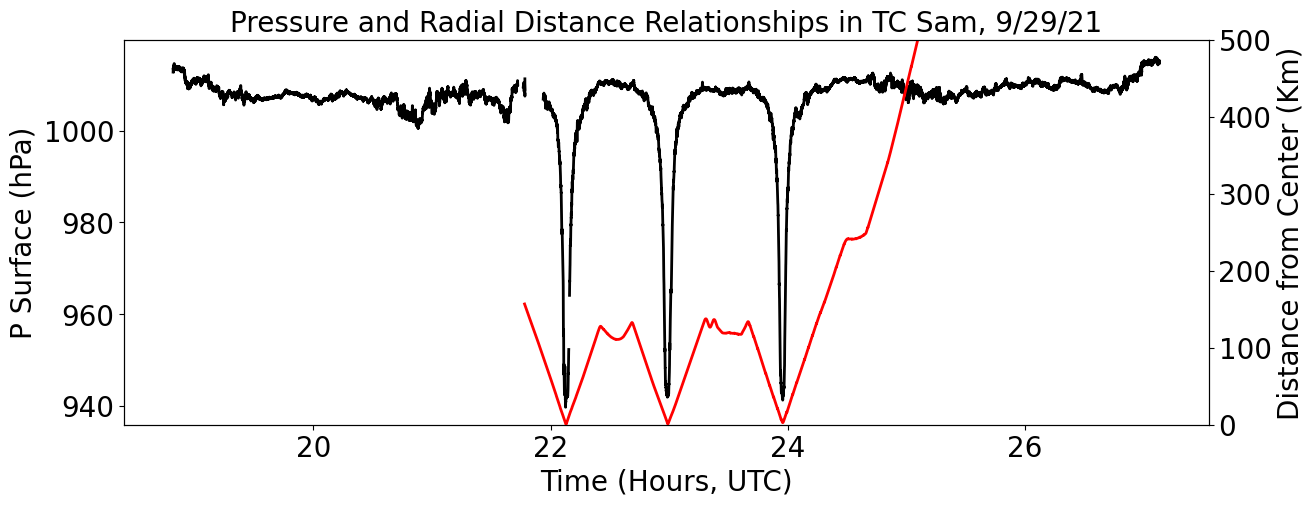

In [35]:
# make a simple plot showing pressure drops overlapping with distance from the tc center
lw = 2
fig = plt.figure( figsize=(14, 5))
helper_fns.change_font_sizes(20, 20)

ax = plt.gca()
ax.plot( samtime, sam_data['PSURF.d'], c='k', linewidth=lw)
ax.set_ylabel( "P Surface (hPa)")
ax.set_title( "Pressure and Radial Distance Relationships in TC Sam, 9/29/21")
ax.set_xlabel("Time (Hours, UTC)")

ax2 = ax.twinx()
ax2.plot( samtime, sam_data['dist'], c='r', linewidth=lw)
ax2.set_ylabel( "Distance from Center (Km)")

ax2.set_ylim( [0, 500])
# ax2.set_ylim( [0, 50])


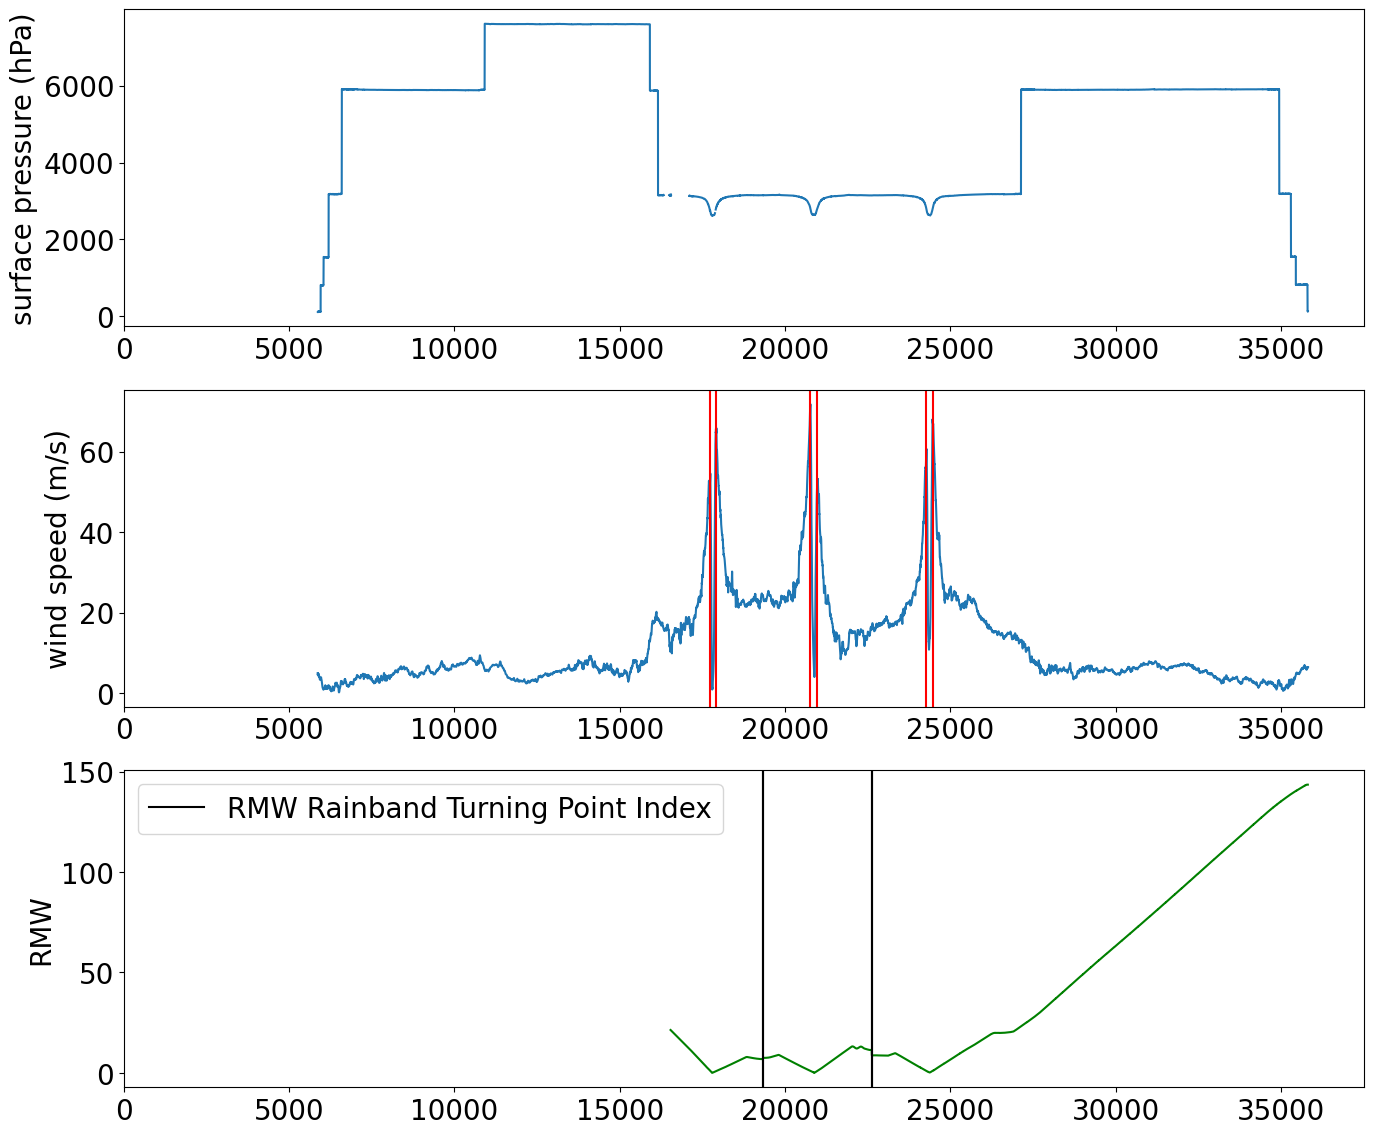

In [36]:
# quick test plot

# print( len( fl_data['Time']))

plt.figure(figsize=(16, 14))
plt.subplot(311)
plt.plot( fl_data['Time'], fl_data['HT.d']) # fl_data['PSURF.d'])
plt.ylabel( 'surface pressure (hPa)')

plt.xlim( [0, 37500])

plt.subplot(312)
plt.plot( fl_data['Time'], spd_avg)
plt.ylabel( 'wind speed (m/s)')


plt.xlim( [0, 37500])

for i in range( len( vpeaks)):
    plt.axvline( x= vpeaks[ i], c='r')
    
plt.subplot( 313)
plt.plot( fl_data['Time'], rmwlist, c='g')
plt.ylabel( 'RMW')

plt.xlim( [0, 37500])
# plt.ylim( [0, 5])

# plot the rainband indices to see if they're in a good spot
for ind in rainbandlist:
    plt.axvline( x=ind, c='k')
    
plt.axvline( x=-5000, c='k', label='RMW Rainband Turning Point Index')
plt.legend()

Confidence intervals found for dist
Confidence intervals found for rmw
Confidence intervals found for time
Confidence intervals found for wind_speed
Confidence intervals found for w
Confidence intervals found for Rain Rate
Confidence intervals found for Theta E
Confidence intervals found for Mixing Ratio
Confidence intervals found for temp


Text(0.5, 0, 'Radius of Maximum Wind')

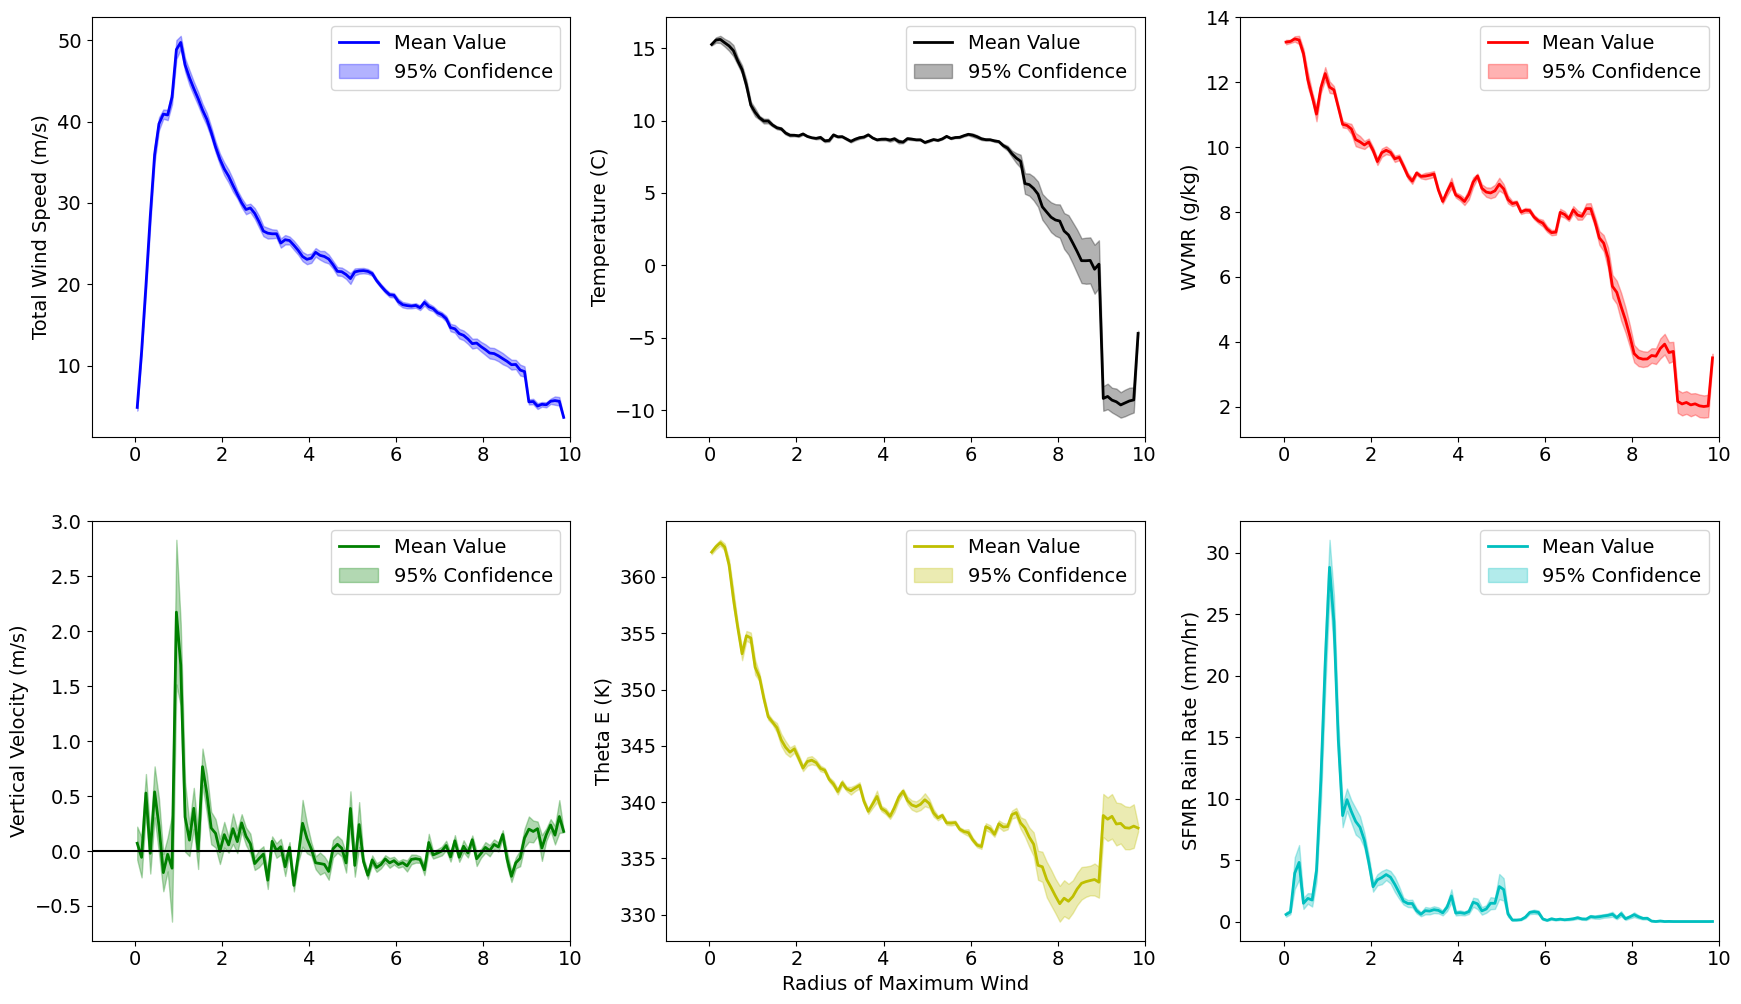

In [56]:
###############################
## make a mean value figure for quantities at different RMW's! 
###############################

plt.figure( figsize=(21, 12))
lw = 2.
helper_fns.change_font_sizes(14, 14)

# make plots of total wind speed and vertical vels along new rmw axes!
plt.subplot(231)

subplots = [ 231, 232, 233, 234, 235, 236]
ylabels = [ "Total Wind Speed (m/s)", "Temperature (C)", "WVMR (g/kg)", "Vertical Velocity (m/s)", "Theta E (K)",
          "SFMR Rain Rate (mm/hr)"]
colors = ['b', 'k', 'r', 'g', 'y', 'c']

# use the var_names list defined way earlier for plotting!
new_var_names = ['wind_speed', 'temp', 'Mixing Ratio', 'w', 'Theta E', 'Rain Rate' ]

for i in range( len( subplots)):

    plt.subplot( subplots[ i])
    plt.ylabel(ylabels[ i])
    plt.xlim( [-1, 10])
    plt.plot( df_binned[ 'midpoints'], df_binned[ new_var_names[ i] + '_mean'], c=colors[i], linewidth=lw, label="Mean Value")

    ax = plt.gca()
    ax.fill_between( df_binned[ 'midpoints'], df_binned[ new_var_names[ i] + '_lowc'], df_binned[ new_var_names[ i] + '_highc'],
                    color=colors[i], alpha=0.3, label=str( int(confidence*100)) + "% Confidence")
    ax.legend()

plt.subplot(234)
plt.axhline(y=0, linewidth = 1.5, c='k')

plt.subplot(235)
plt.xlabel("Radius of Maximum Wind")
